In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, confusion_matrix, auc, matthews_corrcoef, fbeta_score
from sklearn.inspection import permutation_importance

In [114]:
# This is to ensure all plot variables are available and default (in case they were modified in code)
from importlib import reload
plt=reload(plt)

In [115]:
filename = 'baseline_clean.csv'
df = pd.read_csv(filename, dtype=str)
df_raw = df

In [116]:
keep_cols = [
    'is_gambler',
    'atgs_score',
    'Q18',
    # 'r_switch_dir',
    'lotto_count',
    'Q20',
    # 's_switch_dir',
    'delay_count',
]

In [117]:
df = df[keep_cols]

In [118]:
numeric_cols = ['Q18', 'Q20', 'atgs_score', 'lotto_count', 'delay_count']
binary_cols = ['is_gambler']

In [119]:
scaler = MinMaxScaler()
for c in numeric_cols:
    df[c] = scaler.fit_transform(df[[c]])

C:\Users\u4587\AppData\Local\Temp\ipykernel_23128\912673010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = scaler.fit_transform(df[[c]])
C:\Users\u4587\AppData\Local\Temp\ipykernel_23128\912673010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = scaler.fit_transform(df[[c]])
C:\Users\u4587\AppData\Local\Temp\ipykernel_23128\912673010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [120]:
dummies_exclude = numeric_cols + binary_cols

In [121]:
df = pd.get_dummies(df, columns=[i for i in df.columns if i not in dummies_exclude])
y = df['is_gambler']
X = df.drop(['is_gambler'], axis=1)

In [122]:
X.shape

(2017, 5)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [124]:
X_train.shape

(1613, 5)

In [125]:
X_train_resampled.shape

(1948, 5)

In [126]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

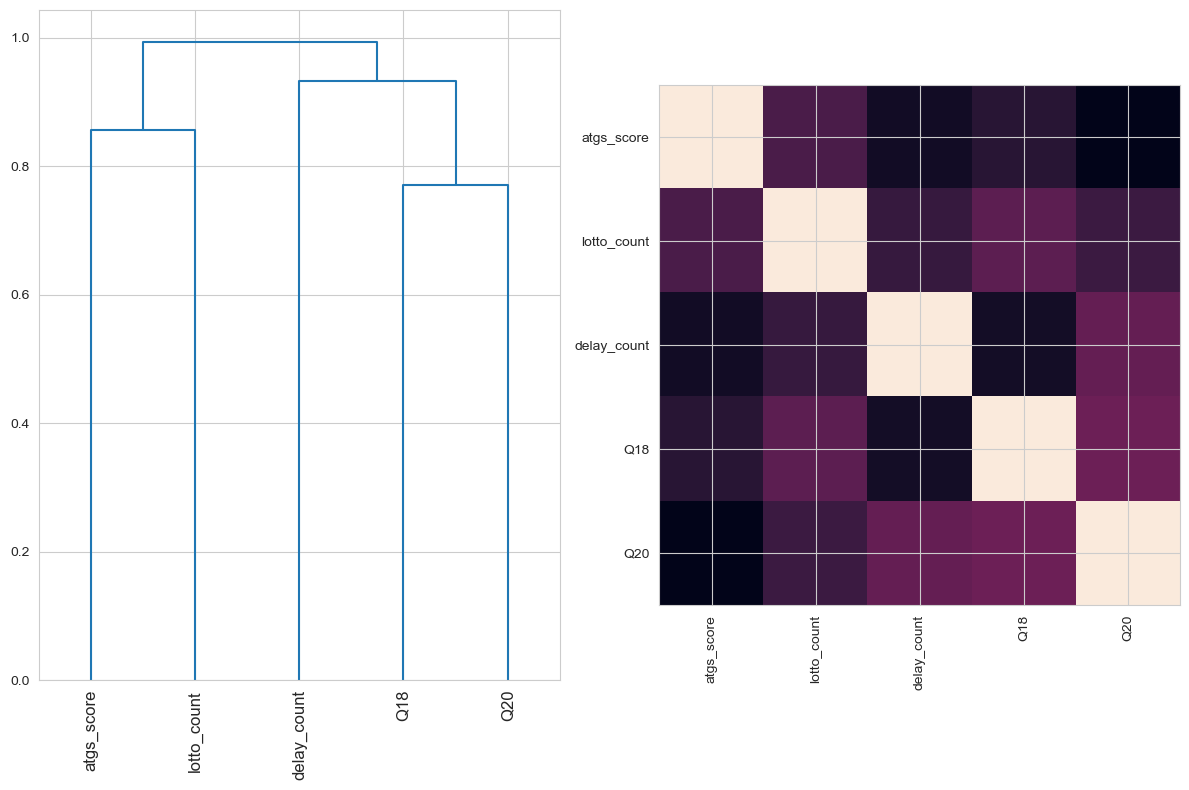

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_train.columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [128]:
X_train = X_train_resampled
y_train = y_train_resampled

In [129]:
X_train.shape

(1948, 5)

In [130]:
X_test.shape

(404, 5)

In [131]:
pl = '1' # the target class to report on in evaluation

In [132]:
param_grid = {
    'Cs': [1, 10, 20],
    'solver': ['newton-cg', 'newton-cholesky']
}
lr = LogisticRegressionCV(random_state=42)
grid_search = GridSearchCV(lr, param_grid, cv=10, scoring='accuracy', n_jobs=-1)  # StratifiedKFold used by default
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test)
y_prob = best_lr.predict_proba(X_test)
best_lr.fit(X_test, y_test)
print(grid_search.best_params_)

{'Cs': 10, 'solver': 'newton-cg'}


In [133]:
accuracy = accuracy_score(y_test, y_pred)
gmean_comb = geometric_mean_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, pos_label=pl)
f1_comb = f1_score(y_test, y_pred, average='macro')
f2_comb = fbeta_score(y_test, y_pred, beta=2, average='macro')
f05_comb = fbeta_score(y_test, y_pred, beta=0.5, average='macro')
roc_auc = roc_auc_score(y_test, y_pred.astype('float'))
precision = precision_score(y_test, y_pred, pos_label=pl)
precision_comb = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, pos_label=pl)
recall_comb = recall_score(y_test, y_pred, average='macro')
phi = matthews_corrcoef(y_test, y_pred)
print('Accuracy:', round(accuracy, 2))
print('G Mean Comb:', round(gmean_comb, 2))
print('F1:', round(f1, 2))
print('F0.5 Comb:', round(f05_comb, 2))
print('F1 Comb:', round(f1_comb, 2))
print('F2 Comb:', round(f2_comb, 2))
print('ROC AUC:', round(roc_auc, 2))
print('Precision:', round(precision, 2))
print('Precision Comb:', round(precision_comb, 2))
print('Recall:', round(recall, 2))
print('Recall Comb:', round(recall_comb, 2))
print('Phi:', round(phi, 2))

Accuracy: 0.61
G Mean Comb: 0.61
F1: 0.64
F0.5 Comb: 0.61
F1 Comb: 0.61
F2 Comb: 0.61
ROC AUC: 0.61
Precision: 0.64
Precision Comb: 0.61
Recall: 0.63
Recall Comb: 0.61
Phi: 0.21


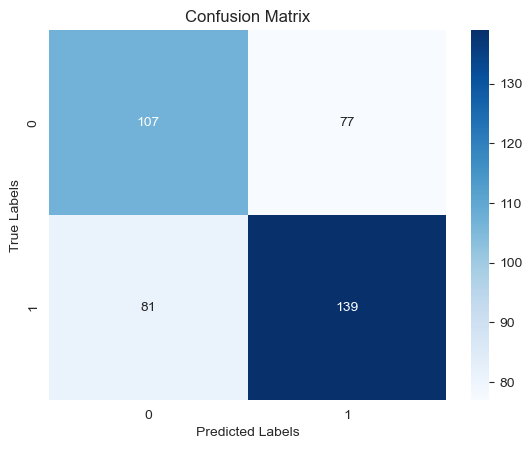

In [134]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

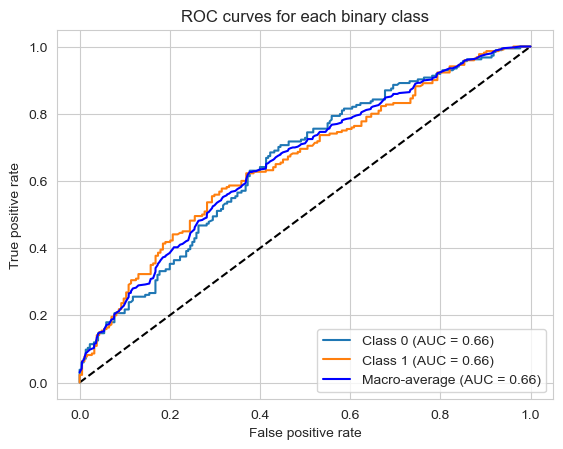

In [135]:
class_num = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_num):
    fpr[i], tpr[i], _ = roc_curve(y_test == str(i), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_num)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(class_num):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= class_num
macro_auc = auc(all_fpr, mean_tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
for i in range(class_num):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot(all_fpr, mean_tpr, 'b-', label='Macro-average (AUC = {:.2f})'.format(macro_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each binary class')
plt.legend(loc='lower right')
plt.show()

In [136]:
coefficients = best_lr.coef_[0]
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": coefficients}, index=X_train.columns
)

feature_importance_sorted = feature_importance.sort_values(by="importance", ascending=False)
feature_importance_sorted = feature_importance_sorted.head(20)

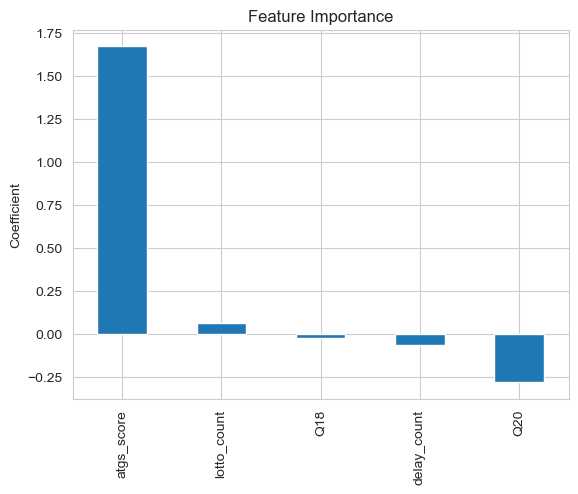

In [137]:
feature_importance_sorted.plot.bar()
plt.xticks(rotation=90)
plt.ylabel("Coefficient")
plt.title("Feature Importance")
plt.legend('',frameon=False)
plt.show()

In [138]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='accuracy', n_jobs=-1)  # StratifiedKFold used by default
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)
best_rf.fit(X_test, y_test)
print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [139]:
accuracy = accuracy_score(y_test, y_pred)
gmean_comb = geometric_mean_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, pos_label=pl)
f1_comb = f1_score(y_test, y_pred, average='macro')
f2_comb = fbeta_score(y_test, y_pred, beta=2, average='macro')
f05_comb = fbeta_score(y_test, y_pred, beta=0.5, average='macro')
roc_auc = roc_auc_score(y_test, y_pred.astype('float'))
precision = precision_score(y_test, y_pred, pos_label=pl)
precision_comb = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, pos_label=pl)
recall_comb = recall_score(y_test, y_pred, average='macro')
phi = matthews_corrcoef(y_test, y_pred)
print('Accuracy:', round(accuracy, 2))
print('G Mean Comb:', round(gmean_comb, 2))
print('F1:', round(f1, 2))
print('F0.5 Comb:', round(f05_comb, 2))
print('F1 Comb:', round(f1_comb, 2))
print('F2 Comb:', round(f2_comb, 2))
print('ROC AUC:', round(roc_auc, 2))
print('Precision:', round(precision, 2))
print('Precision Comb:', round(precision_comb, 2))
print('Recall:', round(recall, 2))
print('Recall Comb:', round(recall_comb, 2))
print('Phi:', round(phi, 2))

Accuracy: 0.59
G Mean Comb: 0.59
F1: 0.63
F0.5 Comb: 0.59
F1 Comb: 0.59
F2 Comb: 0.59
ROC AUC: 0.59
Precision: 0.62
Precision Comb: 0.59
Recall: 0.65
Recall Comb: 0.59
Phi: 0.17


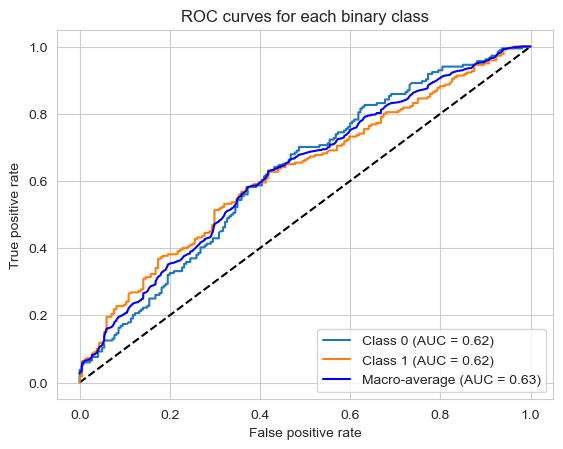

In [140]:
class_num = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_num):
    fpr[i], tpr[i], _ = roc_curve(y_test == str(i), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_num)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(class_num):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= class_num
macro_auc = auc(all_fpr, mean_tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
for i in range(class_num):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot(all_fpr, mean_tpr, 'b-', label='Macro-average (AUC = {:.2f})'.format(macro_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each binary class')
plt.legend(loc='lower right')
plt.show()

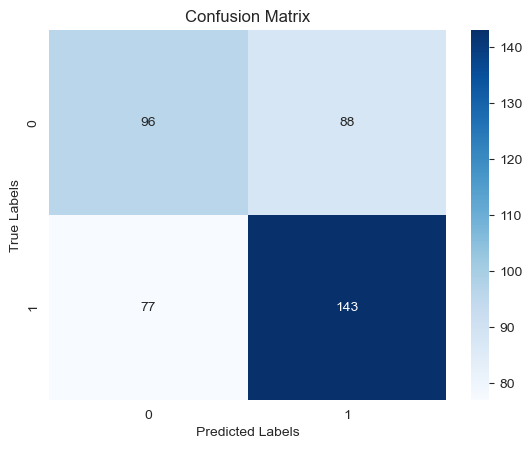

In [141]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

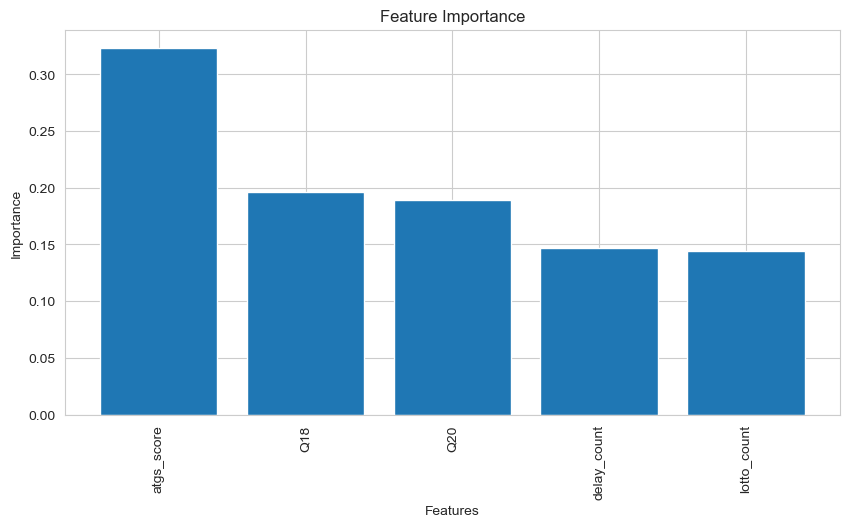

In [142]:
importances = best_rf.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1][:20]
sorted_importances = importances[sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
plt.figure(figsize=(10, 5))
plt.bar(sorted_feature_names, sorted_importances)
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [143]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

In [144]:
# Average the trees in the forest
tree_importances = np.zeros((X_train.shape[1],), dtype=np.float64)
for tree in best_rf.estimators_:
    tree_importances += tree.feature_importances_
tree_importances /= len(best_rf.estimators_)

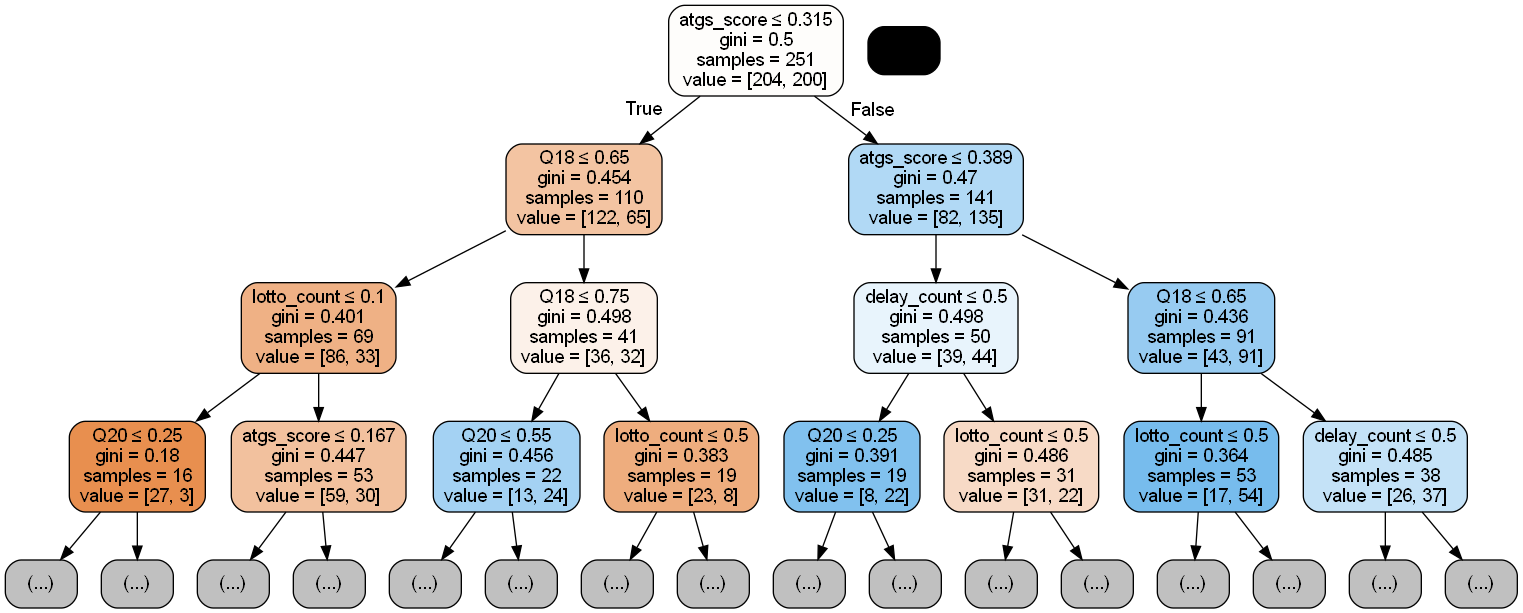

In [145]:
dot_data = export_graphviz(best_rf.estimators_[0], out_file=None,
                           feature_names=X_train.columns,
                           filled=True, rounded=True,
                           special_characters=True,
                           max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [146]:
mdi_importances = pd.Series(
    best_rf[-1].feature_importances_, index=X_train.columns
).sort_values(ascending=True)

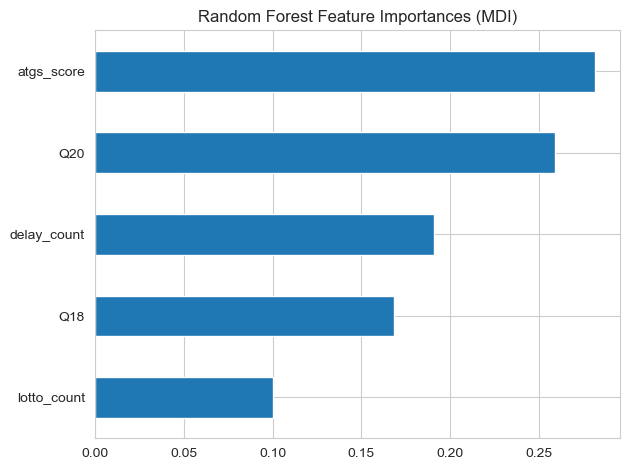

In [147]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

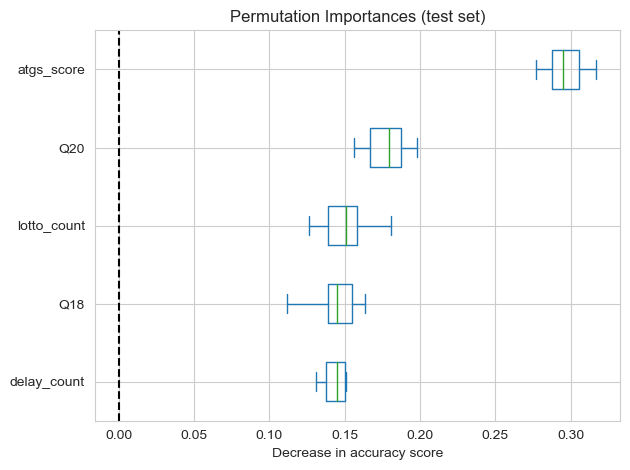

In [148]:
result = permutation_importance(
    best_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

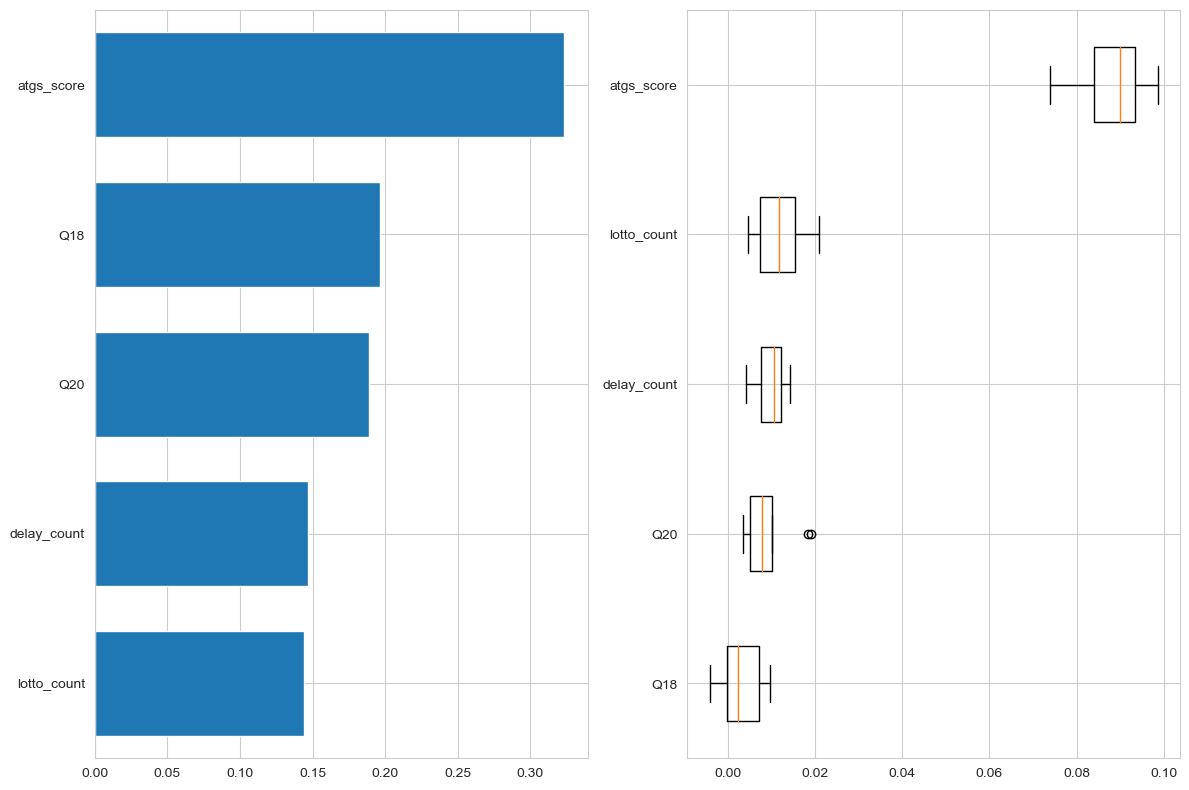

In [149]:
result = permutation_importance(best_rf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(best_rf.feature_importances_)
tree_indices = np.arange(0, len(best_rf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, best_rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X_train.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(best_rf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

In [150]:
param_grid = {
    'C': [0.1, 1, 50, 100, 1000, 10000],
    'kernel': ['linear', 'rbf']
}

all_params = ParameterGrid(param_grid)
# Filter the param grid so that only C values correspond with the kernel type: rbf will have higher values than linear
new_grid = []
for i in all_params:
    if (i['kernel'] == 'linear' and i['C'] <= 20) or (i['kernel'] == 'rbf' and i['C'] > 20):
        _temp = {}
        for k in i.keys():
            _temp[k] = [i[k]]
        new_grid.append(_temp)

svc = SVC(random_state=42, probability=True)
grid_search = GridSearchCV(svc, param_grid=new_grid, cv=10, scoring='accuracy', n_jobs=-1)  # StratifiedKFold used by default
grid_search.fit(X_train, y_train)
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test)
y_prob = best_svc.predict_proba(X_test)
best_svc.fit(X_test, y_test)
best_params = grid_search.best_params_
print(grid_search.best_params_)

{'C': 100, 'kernel': 'rbf'}


In [151]:
accuracy = accuracy_score(y_test, y_pred)
gmean_comb = geometric_mean_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, pos_label=pl)
f1_comb = f1_score(y_test, y_pred, average='macro')
f2_comb = fbeta_score(y_test, y_pred, beta=2, average='macro')
f05_comb = fbeta_score(y_test, y_pred, beta=0.5, average='macro')
roc_auc = roc_auc_score(y_test, y_pred.astype('float'))
precision = precision_score(y_test, y_pred, pos_label=pl)
precision_comb = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, pos_label=pl)
recall_comb = recall_score(y_test, y_pred, average='macro')
phi = matthews_corrcoef(y_test, y_pred)
print('Accuracy:', round(accuracy, 2))
print('G Mean Comb:', round(gmean_comb, 2))
print('F1:', round(f1, 2))
print('F0.5 Comb:', round(f05_comb, 2))
print('F1 Comb:', round(f1_comb, 2))
print('F2 Comb:', round(f2_comb, 2))
print('ROC AUC:', round(roc_auc, 2))
print('Precision:', round(precision, 2))
print('Precision Comb:', round(precision_comb, 2))
print('Recall:', round(recall, 2))
print('Recall Comb:', round(recall_comb, 2))
print('Phi:', round(phi, 2))

Accuracy: 0.57
G Mean Comb: 0.56
F1: 0.61
F0.5 Comb: 0.57
F1 Comb: 0.57
F2 Comb: 0.56
ROC AUC: 0.56
Precision: 0.6
Precision Comb: 0.57
Recall: 0.61
Recall Comb: 0.56
Phi: 0.13


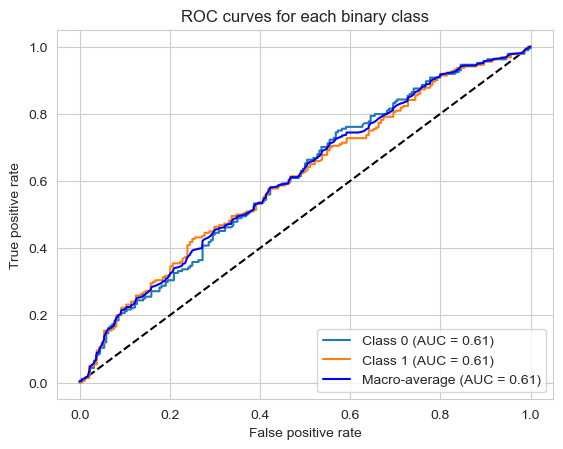

In [152]:
class_num = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_num):
    fpr[i], tpr[i], _ = roc_curve(y_test == str(i), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_num)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(class_num):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= class_num
macro_auc = auc(all_fpr, mean_tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
for i in range(class_num):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot(all_fpr, mean_tpr, 'b-', label='Macro-average (AUC = {:.2f})'.format(macro_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each binary class')
plt.legend(loc='lower right')
plt.show()

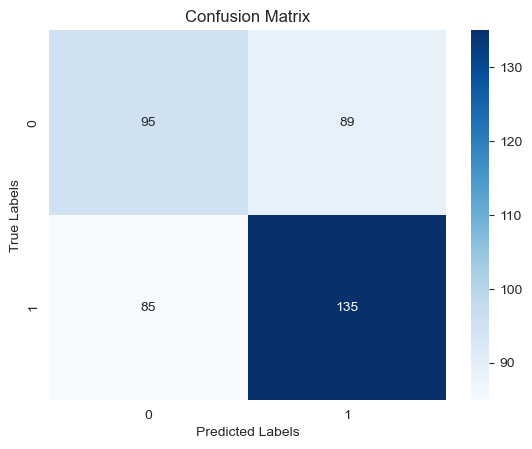

In [153]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [154]:
from scipy.stats import pointbiserialr, pearsonr
from phik import phik_from_array

In [155]:
target_variable = 'is_gambler'
continuous_features = [i for i in numeric_cols]
one_hot_encoded_features = [i for i in df.columns if i not in dummies_exclude]

In [156]:
def compute_correlation(feature_name, target_name, data, method):
    if method == 'pointbiserial':
        return pointbiserialr(data[target_name].astype('int'), data[feature_name])
    elif method == 'pearson':
        return pearsonr(data[target_name].astype('int'), data[feature_name])
    elif method == 'phi':
        # https://phik.readthedocs.io/en/latest/index.html
        return phik_from_array(data[target_name].astype('int'), data[feature_name])

In [157]:
results = []

for feature in continuous_features:
    correlation, p_value = compute_correlation(feature, target_variable, df, method='pointbiserial')
    results.append({'Feature': feature, 'Correlation': correlation, 'P-value': p_value, 'Type': 'Continuous'})

for feature in one_hot_encoded_features:
    correlation = compute_correlation(feature, target_variable, df, method='phi')
    p_value = -99
    results.append({'Feature': feature, 'Correlation': correlation, 'P-value': p_value, 'Type': 'One-Hot Encoded'})

correlation_df = pd.DataFrame(results).set_index('Feature')

In [158]:
correlations = correlation_df[['Correlation', 'P-value']].sort_values(by='Correlation', ascending=False)

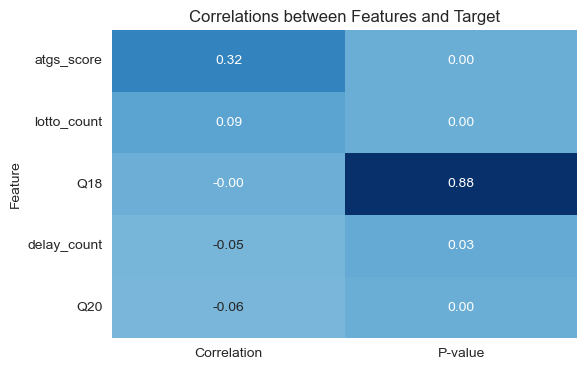

In [159]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlations, annot=True, cmap='Blues', center=0, xticklabels=True, yticklabels=True, fmt='.2f', cbar=False)
plt.title('Correlations between Features and Target')
plt.show()

In [160]:
models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'Support Vector': best_svc
}

feature_ranking = []

for n, m in models.items():
    m.fit(X_train, y_train)

    result = permutation_importance(m, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
    importance = np.round(result.importances_mean, 2)
    feature_ranking.append(list(importance))

In [161]:
f_rank_df = pd.DataFrame(feature_ranking, columns=X_train.columns).T
f_rank_df = f_rank_df.rename(columns={idx: n for idx, n in enumerate(models.keys())})
f_rank_df['importance'] = f_rank_df.apply(lambda x: np.sum(np.abs(x)), axis=1)
f_rank_df = f_rank_df.sort_values(by="importance", ascending=False)

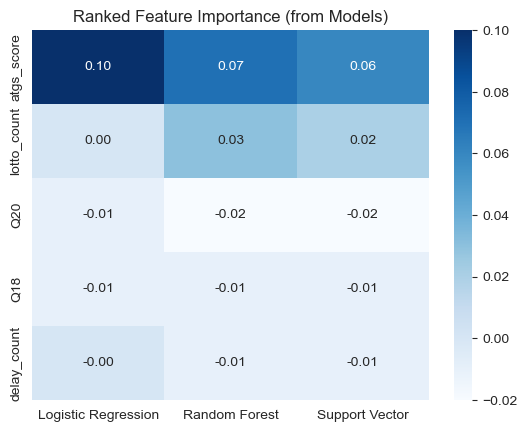

In [162]:
sns.heatmap(f_rank_df[f_rank_df.columns[:-1]], annot=True, cmap='Blues', fmt='.2f')
plt.title('Ranked Feature Importance (from Models)')
plt.show()

In [163]:
f_scores, p_values = f_classif(X_test, y_test)

# Create a DataFrame to display the results
results_df = pd.DataFrame({'F-score': f_scores, 'p-value': p_values}, index=X_train.columns)
results_df = results_df.sort_values(by="F-score", ascending=False)

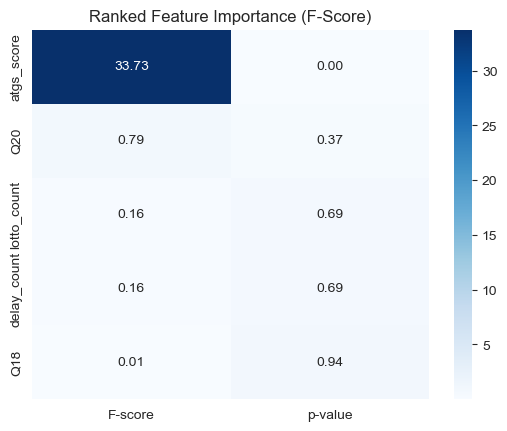

In [164]:
sns.heatmap(results_df, annot=True, cmap='Blues', fmt='.2f')
plt.title('Ranked Feature Importance (F-Score)')
plt.show()

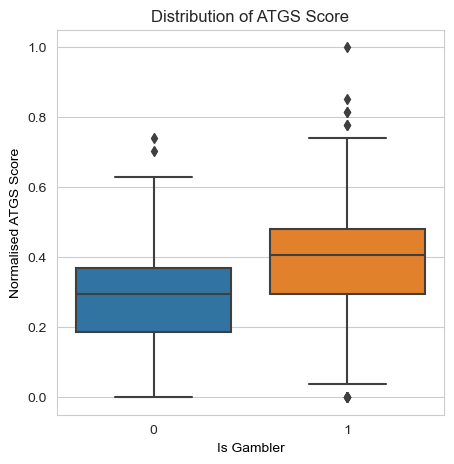

In [165]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(x='is_gambler', y='atgs_score', data=df)
ax.set_ylabel("Normalised ATGS Score", fontsize=10, color='black')
ax.set_xlabel("Is Gambler", fontsize=10, color='black')
plt.title('Distribution of ATGS Score')
plt.show()

In [166]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y = df['atgs_score']
X = df.drop(['atgs_score', 'is_gambler'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_resampled = X_train
y_train_resampled = y_train
X_train_resampled = sm.add_constant(X_train_resampled)
models = {
    'poi': sm.GLM(y_train_resampled, X_train_resampled, family=sm.families.Poisson()),
    'nb': sm.GLM(y_train_resampled, X_train_resampled, family=sm.families.NegativeBinomial())
}
fitted_models = {}
for n, m in models.items():
    print(f'\nResults for: {n}')
    mdl = m.fit()
    fitted_models[n] = mdl
    print(mdl.summary())
    X_test = sm.add_constant(X_test)
    y_pred = mdl.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'MAE = {round(mae, 2)}')
    print(f'MSE = {round(mse, 2)}')
    print(f'RMSE = {round(rmse, 2)}')
    print(f'R2 = {round(r2, 2)}')


Results for: poi
                 Generalized Linear Model Regression Results                  
Dep. Variable:             atgs_score   No. Observations:                 1613
Model:                            GLM   Df Residuals:                     1608
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -980.41
Date:                Sun, 23 Apr 2023   Deviance:                       121.36
Time:                        13:53:26   Pearson chi2:                     106.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002237
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.1368      0.18

In [167]:
# Extract coefficients and their names
coefficients = fitted_models['poi'].params[1:]  # Exclude the intercept
variable_names = list(X_train_resampled.columns)[1:]  # Exclude the constant

# Create a DataFrame
coef_df = pd.DataFrame({'Variable': variable_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values('Coefficient', ascending=False)

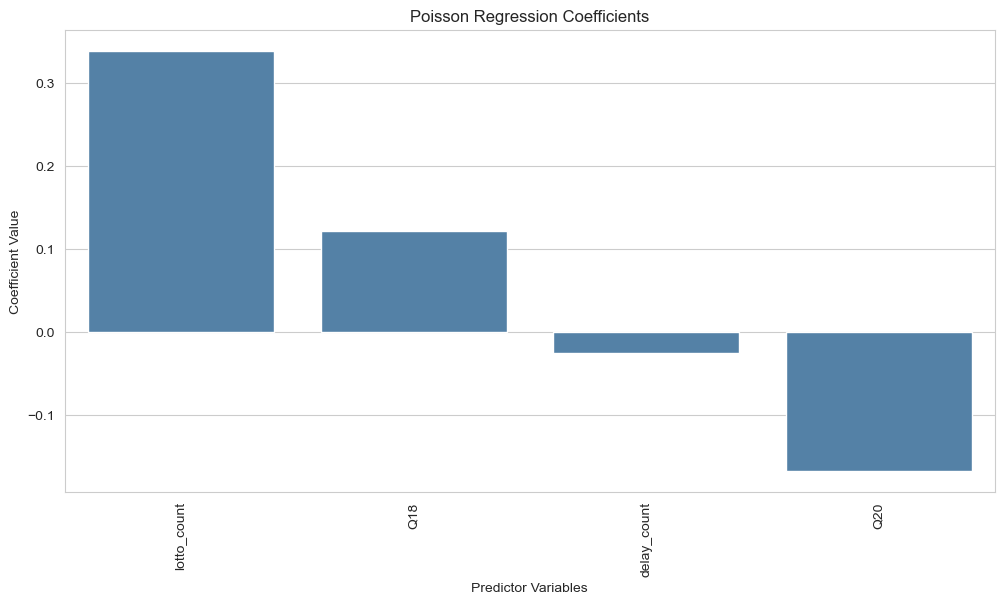

In [168]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Variable', y='Coefficient', data=coef_df, color='steelblue')
plt.title('Poisson Regression Coefficients')
plt.xlabel('Predictor Variables')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()